## Setup
Lets import the librarys and set plotting styles:

In [3]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv
import math

import pymc  as pm
#from   pymc3.backends import SQLite
from   scipy  import optimize
from   aesara import tensor as tt

import matplotlib.pyplot as plt
import arviz as az

Import and visulaise the sata

In [4]:
#dat = pd.read_csv('data/sample_data_for_doug_defthresh_0.1.csv')
#coverChange = dat['Canopy_cover_change'].values
#Tchange = dat['T_change'].values

dat = pd.read_csv("data/Regional-Timeseries_CWD_2000-2022.csv")
regions = dat["Regioes"].values
cwd = dat["Mean_CWD"].values
date = pd.to_datetime(dat["DATE"])
print(date)

0      2000-01-01
1      2000-01-01
2      2000-01-01
3      2000-01-01
4      2000-01-01
          ...    
1375   2022-12-01
1376   2022-12-01
1377   2022-12-01
1378   2022-12-01
1379   2022-12-01
Name: DATE, Length: 1380, dtype: datetime64[ns]


In [5]:
def datetime_to_decimal_year(dates):
    year = dates.dt.year
    start = pd.to_datetime(year.astype(str) + '-01-01')
    end = pd.to_datetime((year + 1).astype(str) + '-01-01')
    return year + ((dates - start).dt.total_seconds() / ((end - start).dt.total_seconds()))
decimal_year = datetime_to_decimal_year(date)

print(decimal_year)

decimal_year = decimal_year-2000

0       2000.000000
1       2000.000000
2       2000.000000
3       2000.000000
4       2000.000000
           ...     
1375    2022.915068
1376    2022.915068
1377    2022.915068
1378    2022.915068
1379    2022.915068
Name: DATE, Length: 1380, dtype: float64


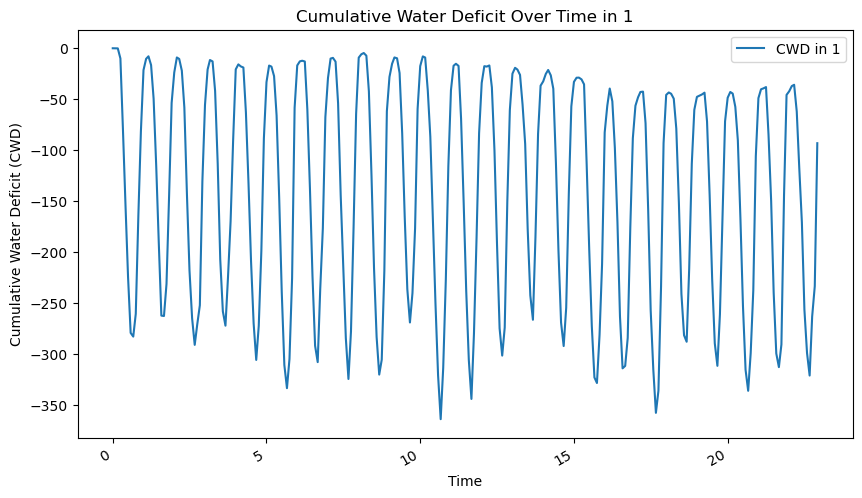

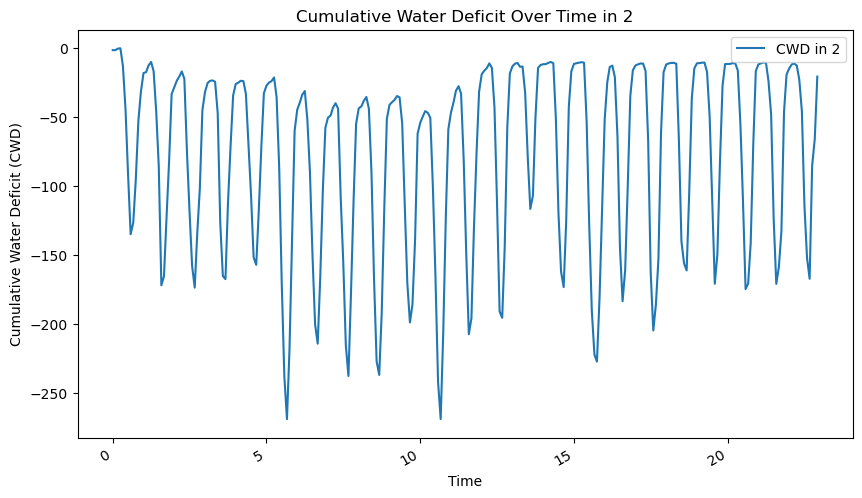

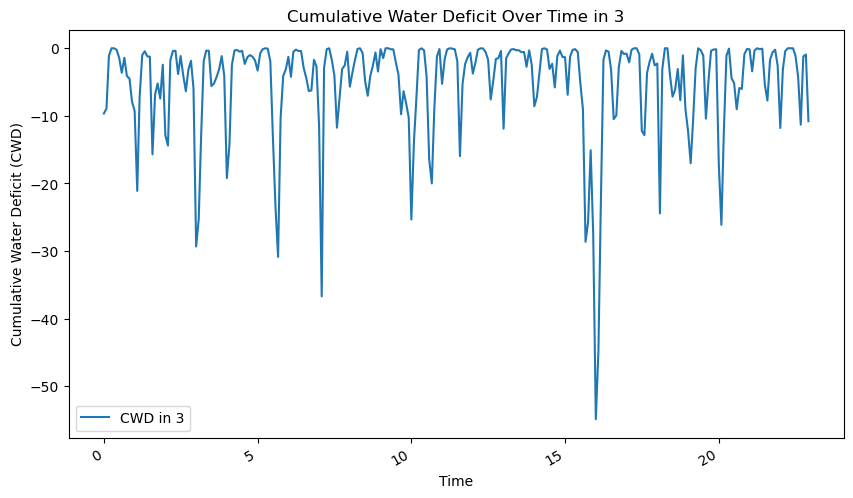

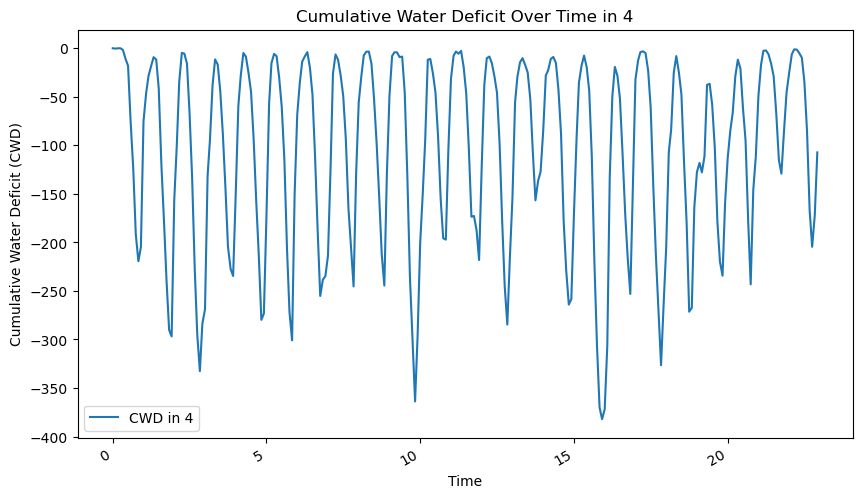

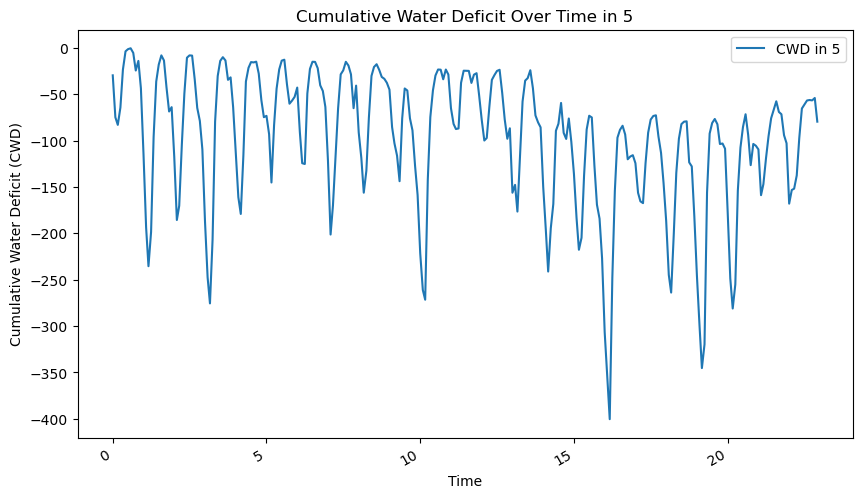

In [6]:
#def scatter_data():
#    fig = plt.figure(figsize=(4, 4))
#    ax = fig.add_subplot(111, xlabel="Canopy Cover Change (%)", ylabel="Temp change($^\circ$C)")
#    ax.plot(coverChange, Tchange, "x", c = 'b', label="sample data")
#    plt.legend(loc=0);
#    return ax
    
#ax = scatter_data()

#def scatter_data():
 #   fig = plt.figure(figsize=(10, 6))
 #   ax = fig.add_subplot(111, xlabel="Time", ylabel="Cumulative Water Deficit (CWD)")
 #   ax.plot(decimal_year, cwd, "-", c = 'b', label="CWD over time")
 #   fig.autofmt_xdate()
 #   plt.legend(loc=0);
 #   plt.title('Cumulative Water Deficit Over Time')
 #   return ax
    
#ax = scatter_data()


# Timeseries for different regions
def scatter_data_by_region():
    regions_unique = dat["Regioes"].unique()
    
    for region in regions_unique:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, xlabel="Time", ylabel="Cumulative Water Deficit (CWD)")
        
        mask = dat["Regioes"] == region
        ax.plot(decimal_year[mask], cwd[mask], "-", label=f"CWD in {region}")
        
        fig.autofmt_xdate()
        plt.legend(loc=0)
        plt.title(f'Cumulative Water Deficit Over Time in {region}')
        plt.show()

scatter_data_by_region()

## Model description
This example uses a simple linear regression model to tease out local tempeture responses to changes in tree cover. Bayesian Inference maybe a bit overkill for the task, but its a great baseline for noiser data, none-linear models, or more detailed research questions (i.e impact of cover change on heat extremes).

The inpedendant variable in the model is \% Canopy Cover Change ($\Delta CC$), and the response variable is change in tempetature ($\Delta T$). There maybe other region-wide changes in tempurature not directly linked with canopy loss (i.e climate change), which is represented by the intercept ($T_0$). There will also be 'noise' assocaiated with other factors influanceing tempature change not considered in the model ($\epsilon$). The parameter we are interested in is the change in tempuarture per \% $\Delta CC$ ($\beta$):
\begin{eqnarray}
    \Delta T (CC, T_0, \beta) &=& T_0 + \beta \times \Delta CC \\[1em]
\end{eqnarray}


This gives us a nice, simple 3 parameter regression model $\gamma = \{T_0, \beta, \epsilon \}$ that need to be optimised against observations of burnt area.  


## Bayesian model definition
A simple explanation of Baye's law is:

\begin{equation}
    P(\gamma|X) \propto P(\gamma)\cdot P(X|\gamma)
\end{equation}

where $X$ is our data (in our case, observations of $\Delta T$), and $\gamma$ our set of unexplained parameters that describe the response of our _proposed understanding_ of this system as it varies with $X$.

### Prior definitions
Because I have no idea what the uncertainty on the hyperparameters should look like, I've made the priors as uninformed as possible. Some of them could have more information or distributions based on updated qualitative knowledge of the bounds, but we can play around with that later.

Our priors assume that $T_0$ is most likely to be $= 0$ (actually, for the region we could look at the long term temp. record in none-deforested areas and use that as a prior, but it might make little difference as we'll see at the end), but we have little confidnce in that. So I have set a large uncertainty bound on this. We thereofre represnt this with a normal distribution with mean 0 and sdev of 20:

\begin{eqnarray}
    P(T_0 = x) &=& \mathcal{N}(x, 0, 20) \\[1em]
    \mathcal{N}(x, \mu, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\left(\frac{x - \mu}{\sigma}\right)^2\right\}
\end{eqnarray}

A good prior assumption for $\beta$ is the null hypothosis that Canopy Cover change has no influance on tempuature, so the most likely value of $\beta$ is also $0$. Again, we suspect this is probably wrong, so set large uncertainty bounds:

\begin{eqnarray}
    P(\beta= x) &=& \mathcal{N}(x, 0, 1) \\[1em]
\end{eqnarray}

That that this means our prior says that a negative change in termpature due to canopy cover change is just as likely as a postive.

Finally, we assume the noise outside the model, $\gamma$ is unbiases and independant of canopy cover or canopy cover change. Noise cannot be less than zero, so we present $\gamma$ with a generous log-normal distribution:
\begin{eqnarray}
    P(\beta= x) &=& \mathcal{N}(log(x), log(0), 21) \\[1em]
\end{eqnarray}

Back to the code.., `pymc` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `model` at the mo, but feel free to call it something more imaginitive

In [20]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    epsilon = pm.LogNormal("epsilon", 0, 10)
    cwd0 = pm.Normal("cwd0", 0, sigma=20)
    beta = pm.Normal("beta", 0, sigma=20)

    prediction = cwd0 + beta * decimal_year

### Posterior sampling
Bayesian inference updates all these proirs on light of observations. To do thos, we need to define a $P(X|\gamma)$. Again, we are summing errors or noise is indepandant of our models variables, and therefore the likelihood of $X$ give $\gamma$ is a simple normal distribution:

\begin{eqnarray}
    P(X| \gamma) &=& \Pi_i^n \mathcal{N}({x_i}, \Delta T (CC_i), \epsilon) \\[1em]
\end{eqnarray}

Note that this probablity is multtplitive.. This has two implications: 
1. The more observations we use, the less influance the parameters have. With big datasets, priors do little more than set phyisical bounds.
1. pymc actually works on log-probablity $P(X | \gamma)$ can get very small very quickly. We dont have to worry about this nor, but its worth bearing in mind for if we start implementing custom functions.

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to infer the posterior solutions for each of the model parameters. In this case we are using a  No-U-Turn (NUTS) sampling (which is the new kid on the block), which is amazing to read about, but probably not here. 

In [ ]:
with model:    
    # Define likelihood
    likelihood = pm.Normal("y", mu=prediction, sigma=epsilon, observed=cwd)
    
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    step=pm.Metropolis()
    trace = pm.sample(1000, step=step, return_inferencedata=True, chains=1)

C:\Users\igor_\anaconda3\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [cwd0]
>Metropolis: [beta]


C:\Users\igor_\anaconda3\Lib\site-packages\pymc\step_methods\metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


## looking at the results

### The inference
We can see how the inference did by plotting the trace. The right shows each sampled paramater value in turn, and the left shows the reultsant distribution. Basically,after some initial parameter samples, NUTS settles down to sampling a parameter combination based on the likeihood of that paramater combo. That means that to get an idea of the likihood of our parameters, we just collect all these samples.

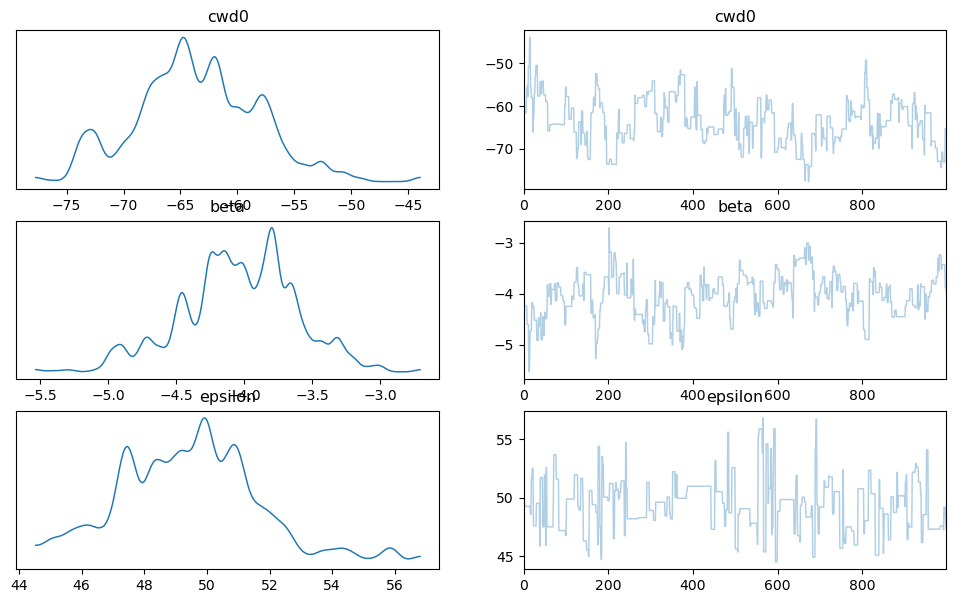

In [29]:
az.plot_trace(trace, figsize=(12, 7));

Co-variation in parameters can be important, specially in more complicated models than this. Although its hard to visualise co-variation in multi-dimentional paramater space, a paired plot can give some cool insights. There are more adavnce tools for exploring parameter space that we can look at later if we need.

Taking the left column parameter beta as an example, the values on the x-axis represent all possible values of beta for each sample (n=1000 in this case). The likelyood of the most extreme case in this scenario would be when beta takes the lowest value, and for cwd example, this would represent the driest scenario (negative slope) that beta can assume (the steepest slope of the distribution).

array([[<Axes: ylabel='beta'>, <Axes: >],
       [<Axes: xlabel='cwd0', ylabel='epsilon'>, <Axes: xlabel='beta'>]],
      dtype=object)

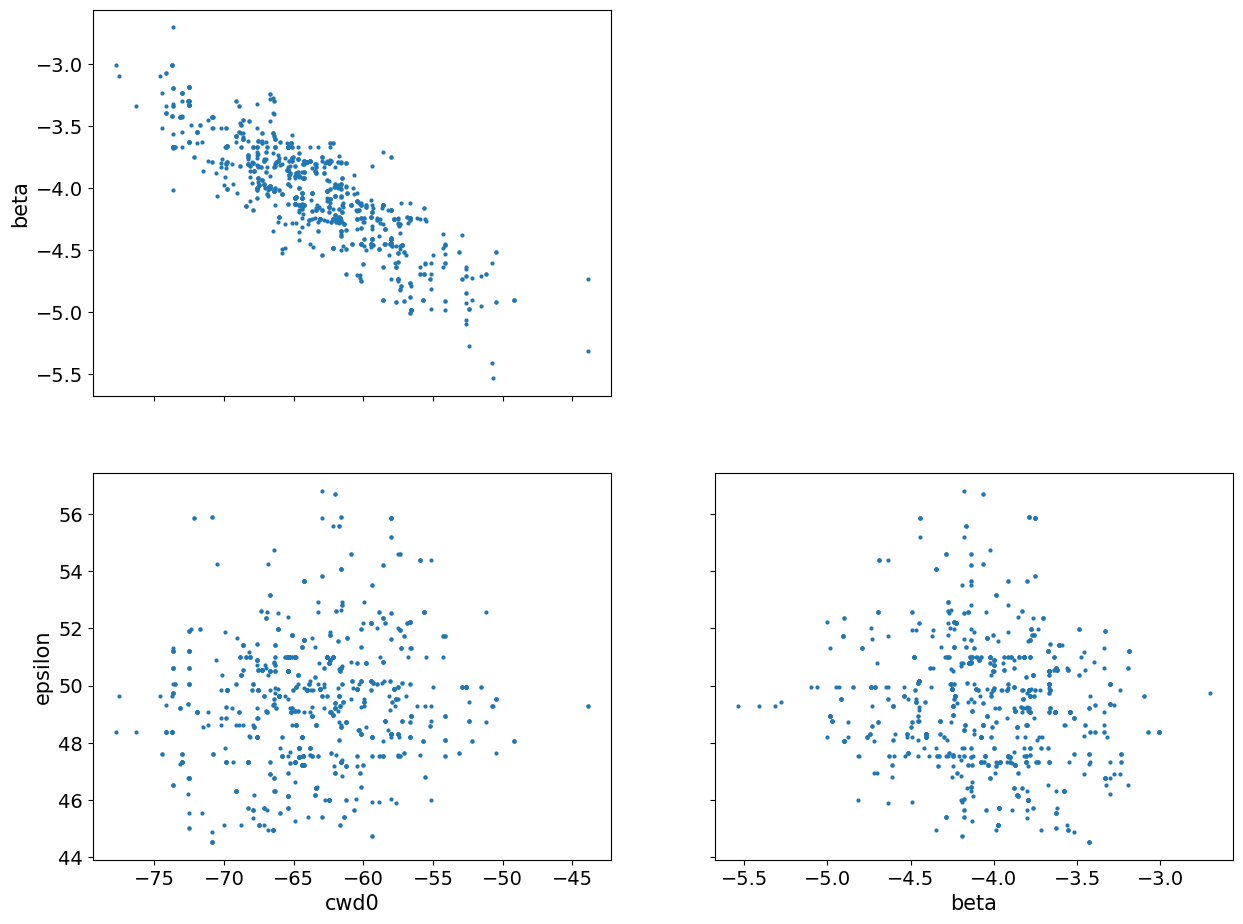

In [30]:
az.plot_pair(trace)

### The linear model
We can now look at what the model predicts. `pymc` recently had a major overhaul, and I;m still getting my head round visualisations. There will be a better way of doing all this once I do

First off (and again, something that is probably more easily done in `pymc` or `az` once I've learnt soem more), we define a function for sampling all the parameters in our "trace", and build the model taht considers each paramater in turn.

In [31]:
def select_post_param(name): return np.ndarray.flatten(trace.posterior[name].values)

def sample_model(i): 
        return select_post_param('cwd0')[i] + select_post_param('beta')[i] *decimal_year

Lets plot out the scatter again with the predictive model. There are two levels of uncertainty in the model. Below, in red, includes our quantified noise. So this is total uncertainty in the model which is useful to do a full predictive likely change in tempuature when canopy cover changes, or in detection-attribution studies. In grey is the uncertainty due to things we include in the model - i.e canopy cover change (or in the exemple of cwd. This is useful for looking at predicting change caused soly by canopy cover change. I've also added the most likely line, though its the uncertainty ranges that are much more important

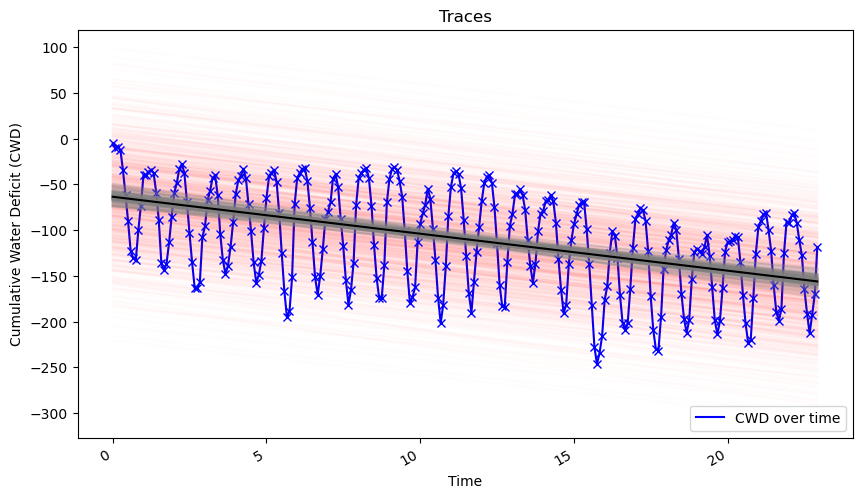

In [39]:
ax     = scatter_data()
idx    = range(0, len(select_post_param('cwd0')), 10)
cwd0_m   = select_post_param('cwd0').mean()
beta_m = select_post_param('beta').mean()

for i in idx:
    for noise in np.random.normal(0, select_post_param('epsilon')[i], 10):
        plt.plot(decimal_year, sample_model(i) + noise, c = 'red', alpha=0.01);

ax.plot(decimal_year, cwd, 'x', c = 'b')
for i in idx: plt.plot(decimal_year, sample_model(i),c='gray', alpha=0.2);
    
plt.plot(decimal_year, cwd0_m + decimal_year* beta_m, c='k'),
         #label='Temp. change = {:.2f} + {:.2f}* Cover Change'.format(T0_m, beta_m))

plt.legend(loc=4)
plt.title("Traces")
plt.show()

The important result is the uncertainty in the $T_0$. 

In [10]:
qs = [0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]

pd.DataFrame(data = {'percentiles': 100*np.array(qs), 'T0': np.quantile(select_post_param('T0'), qs)})

,percentiles,T0
0,1.0,0.177356
1,5.0,0.185676
2,10.0,0.189817
3,50.0,0.205014
4,90.0,0.220086
5,95.0,0.224354
6,99.0,0.232556


This might change with new data, but last time I ran this with the example, that means the likely  tempuature change per \% Canopy Cover Change is 0.186&degC; (2nd row) - 0.225&degC; (5th row) based on the 5-95\%ile

In [16]:
# Applying the Bayesian model in each region
def apply_bayesian_model():
    regions_unique = dat["Regioes"].unique()
    
    for region in regions_unique:
        mask = dat["Regioes"] == region
        
        # Modelo Bayesiano
        with pm.Model() as model:
            # priors
            epsilon = pm.LogNormal("epsilon", 0, 10)
            cwd0 = pm.Normal("cwd0", 0, sigma=20)
            beta = pm.Normal("beta", 0, sigma=20)

            # Prediction
            mu = cwd0 + beta * decimal_year[mask]

            # Likelihood
            likelihood = pm.Normal("y", mu=mu, sigma=epsilon, observed=cwd[mask])

            # Inference
            step = pm.Metropolis()
            trace = pm.sample(1000, step=step, return_inferencedata=True, chains=1)
        
        # Trace Figure
        az.plot_trace(trace, figsize=(12, 7))
        plt.suptitle(f'Trace Plots for {region}', y=1.02)
        plt.show()
        
        az.plot_pair(trace)
        plt.suptitle(f'Plots for {region}', y=1.02)
        plt.show()
        
        def select_post_param(name): 
            return np.ndarray.flatten(trace.posterior[name].values)

        def sample_model(i): 
            return select_post_param('cwd0')[i] + select_post_param('beta')[i] * decimal_year[mask]

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, xlabel="Time", ylabel="Cumulative Water Deficit (CWD)")
        
        ax.plot(decimal_year[mask], cwd[mask], 'x', c='b')
        idx = range(0, len(select_post_param('cwd0')), 10)
        cwd0_m = select_post_param('cwd0').mean()
        beta_m = select_post_param('beta').mean()

        for i in idx:
            for noise in np.random.normal(0, select_post_param('epsilon')[i], 10):
                plt.plot(decimal_year[mask], sample_model(i) + noise, c='red', alpha=0.01)
        
        for i in idx: 
            plt.plot(decimal_year[mask], sample_model(i), c='gray', alpha=0.2)
        
        plt.plot(decimal_year[mask], cwd0_m + decimal_year[mask] * beta_m, c='k')
                 #label='CWD change = {:.2f} + {:.2f}* Cover Change'.format(cwd0_m, beta_m))

        plt.legend(loc=4)
        plt.title(f"Traces for {region}")
        plt.show()

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [cwd0]
>Metropolis: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 39 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


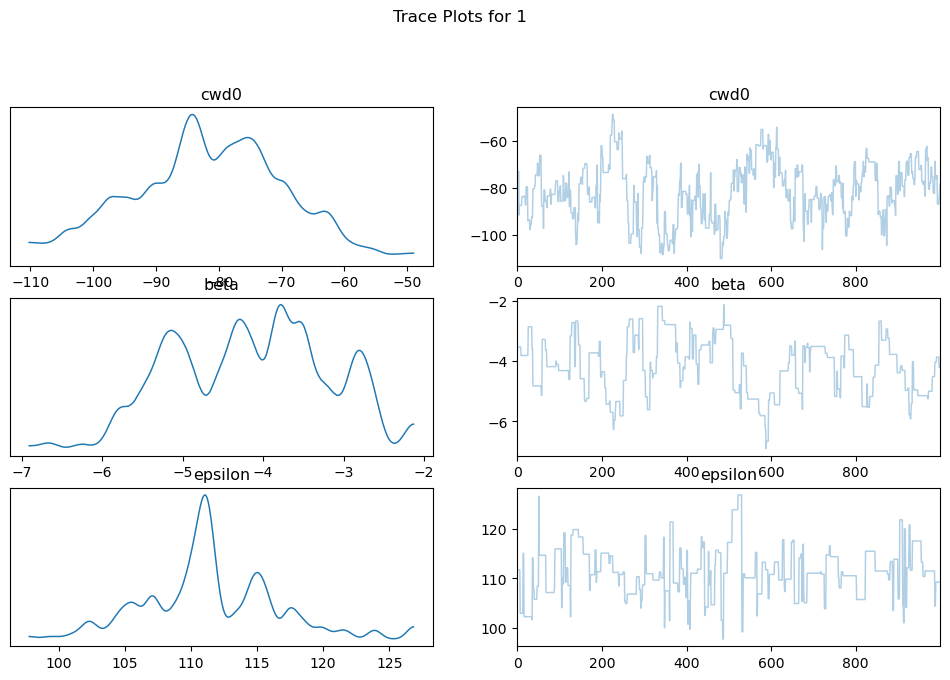

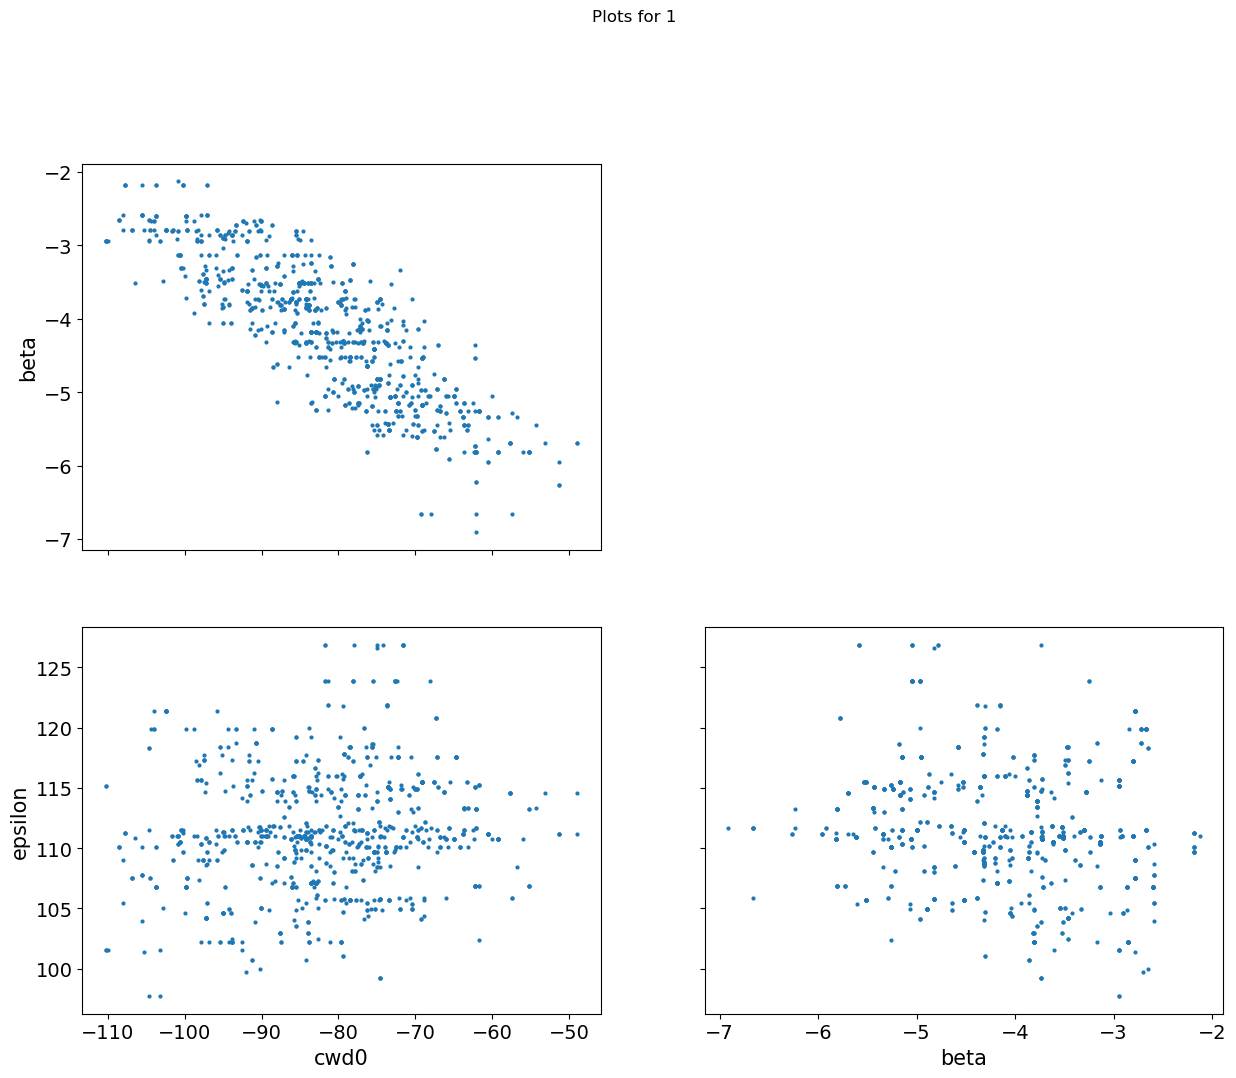

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


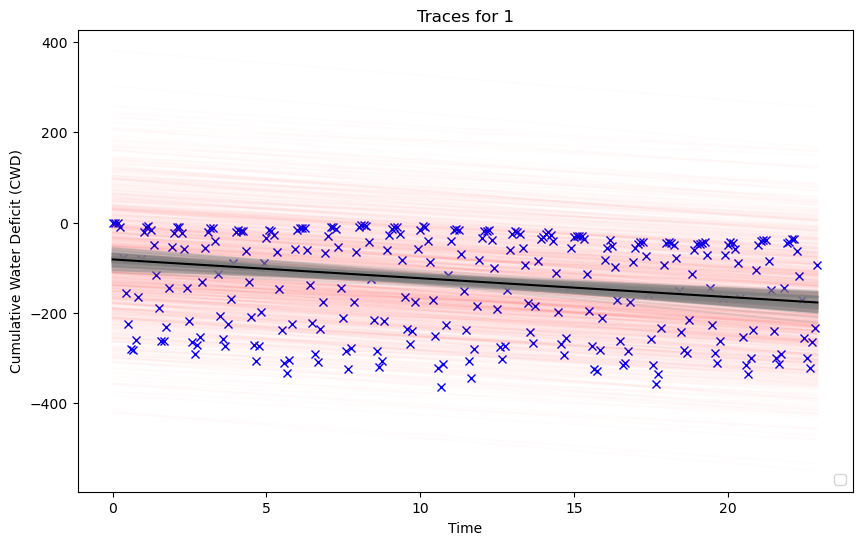

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [cwd0]
>Metropolis: [beta]


C:\Users\igor_\anaconda3\Lib\site-packages\pymc\step_methods\metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 38 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


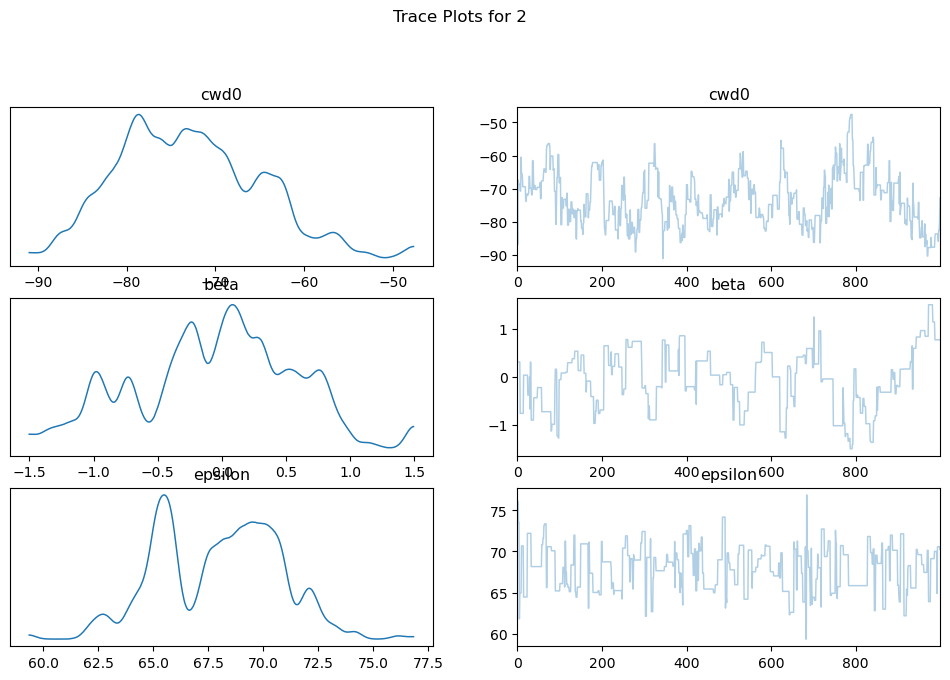

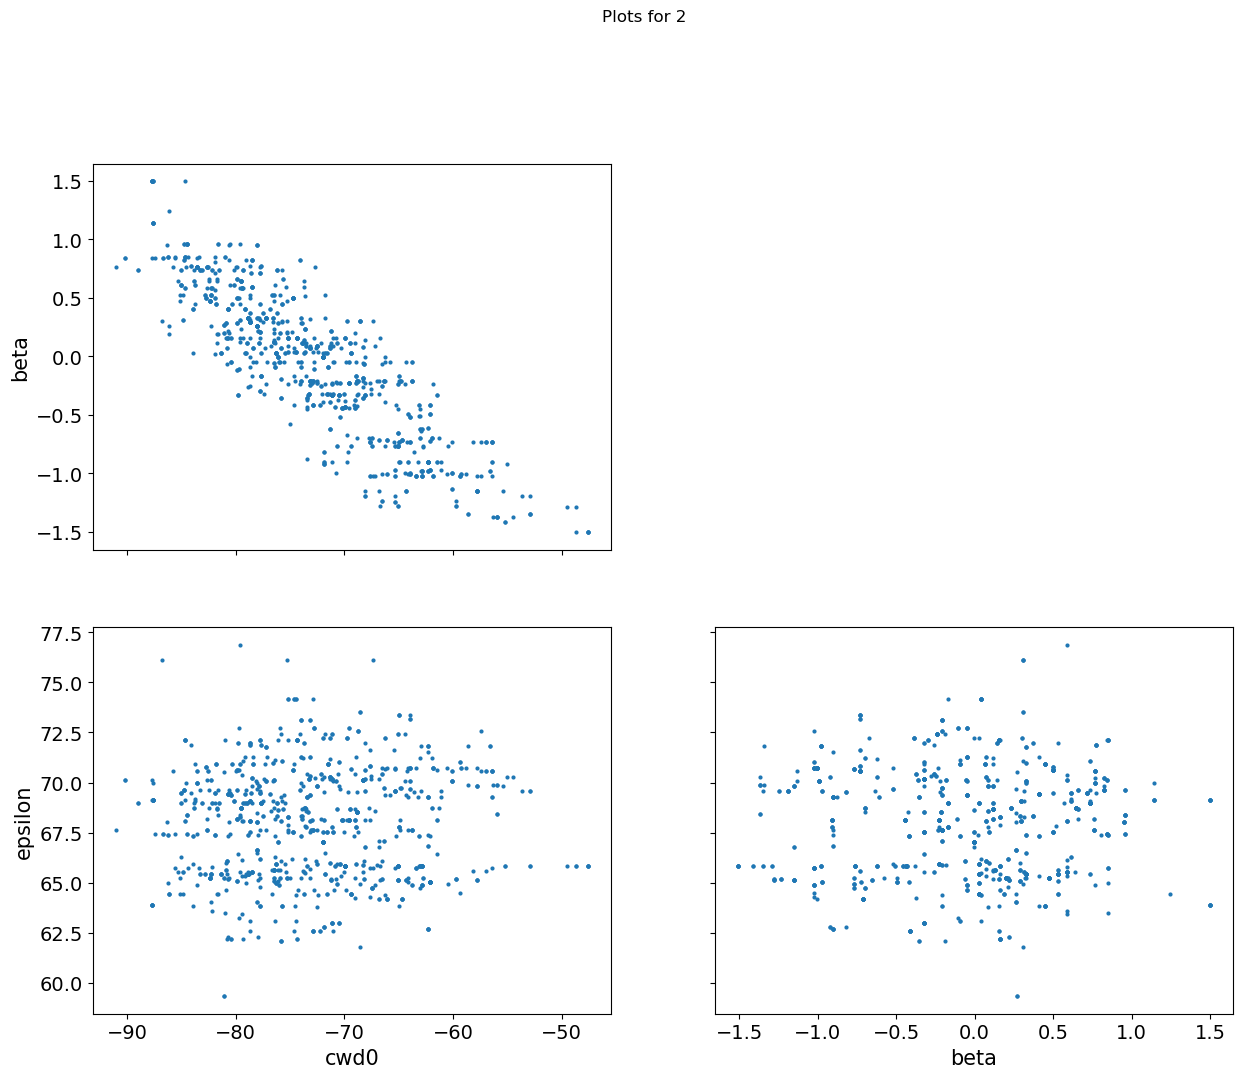

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


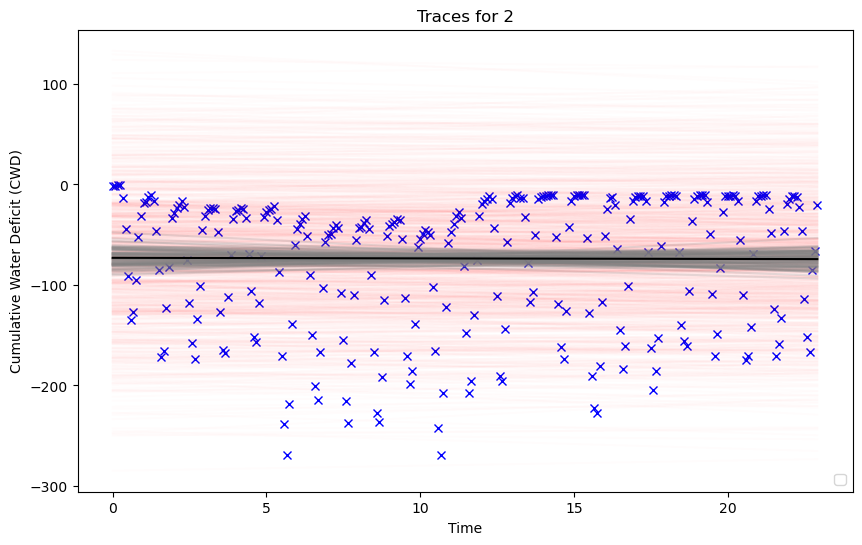

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [cwd0]
>Metropolis: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 39 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


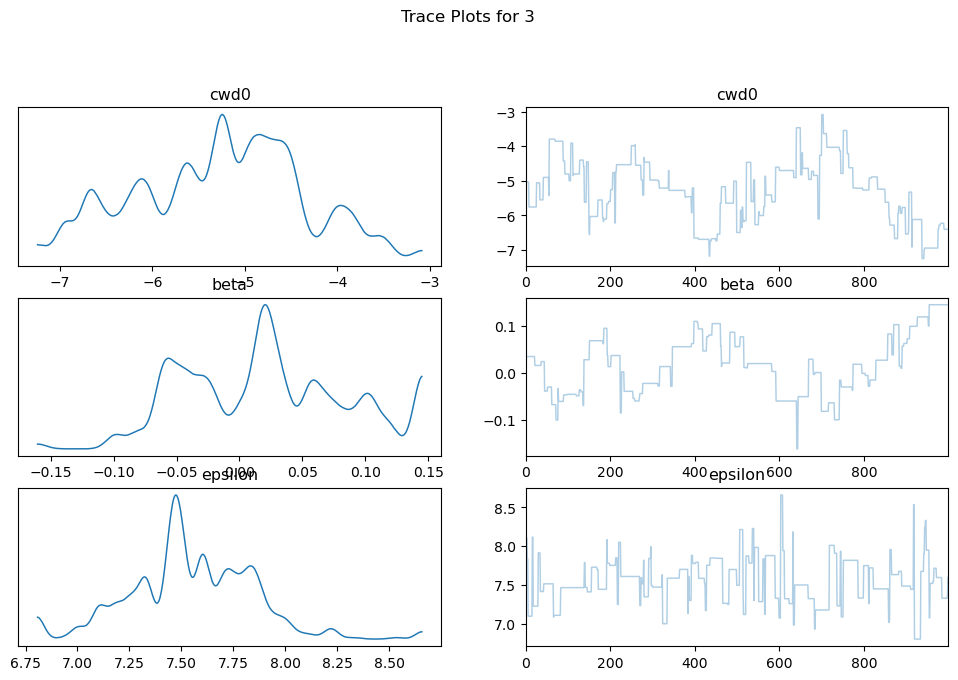

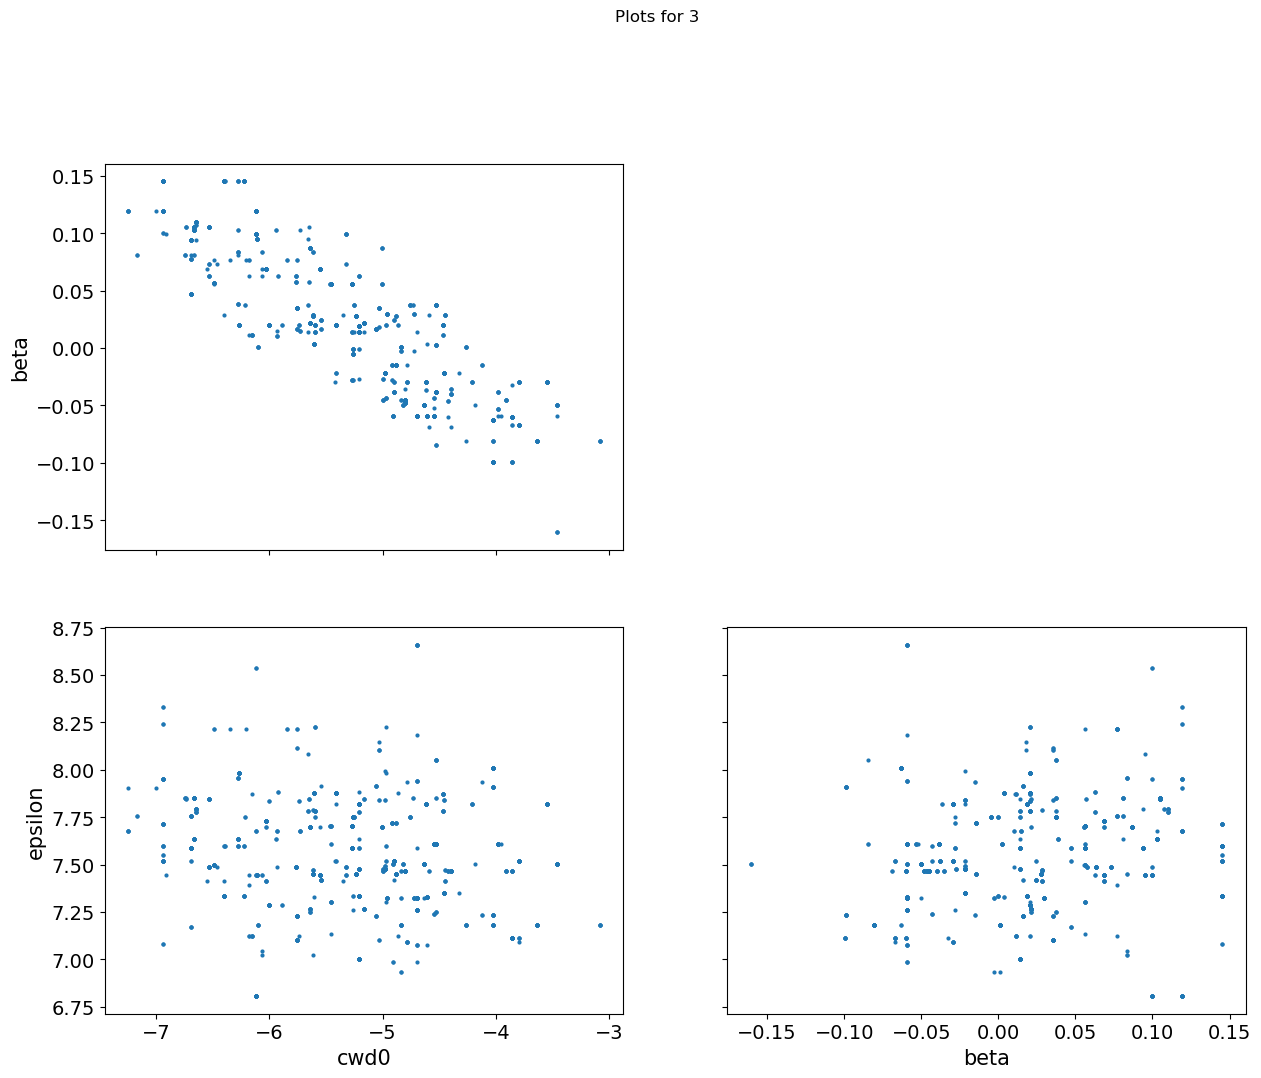

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


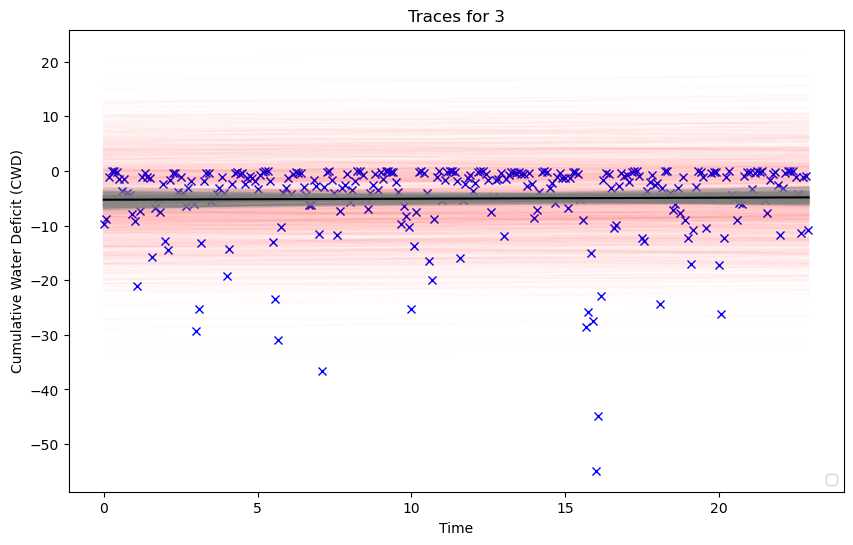

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [cwd0]
>Metropolis: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 40 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


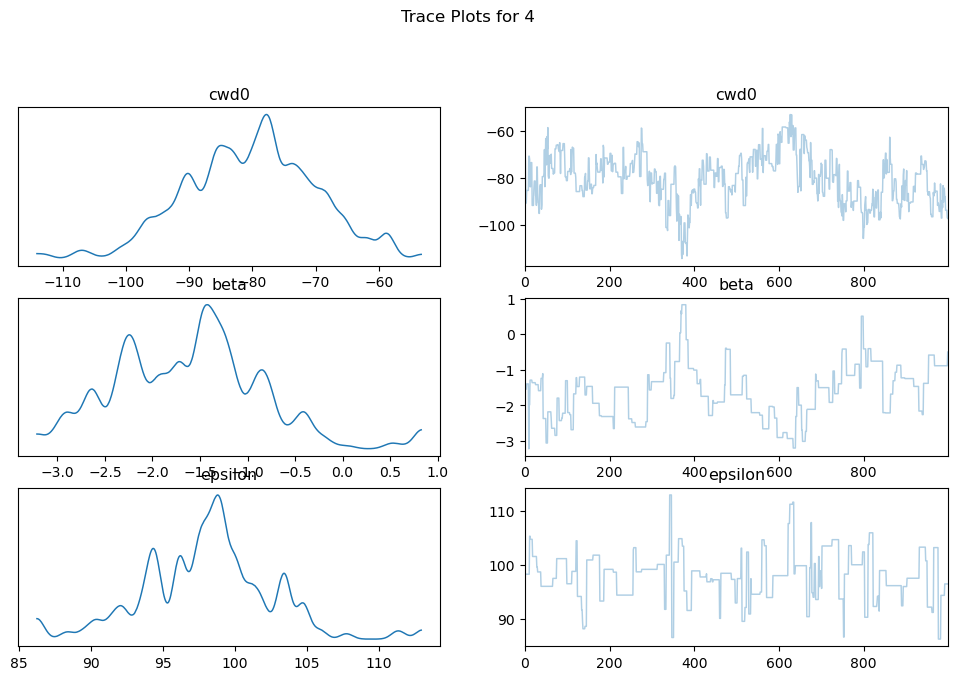

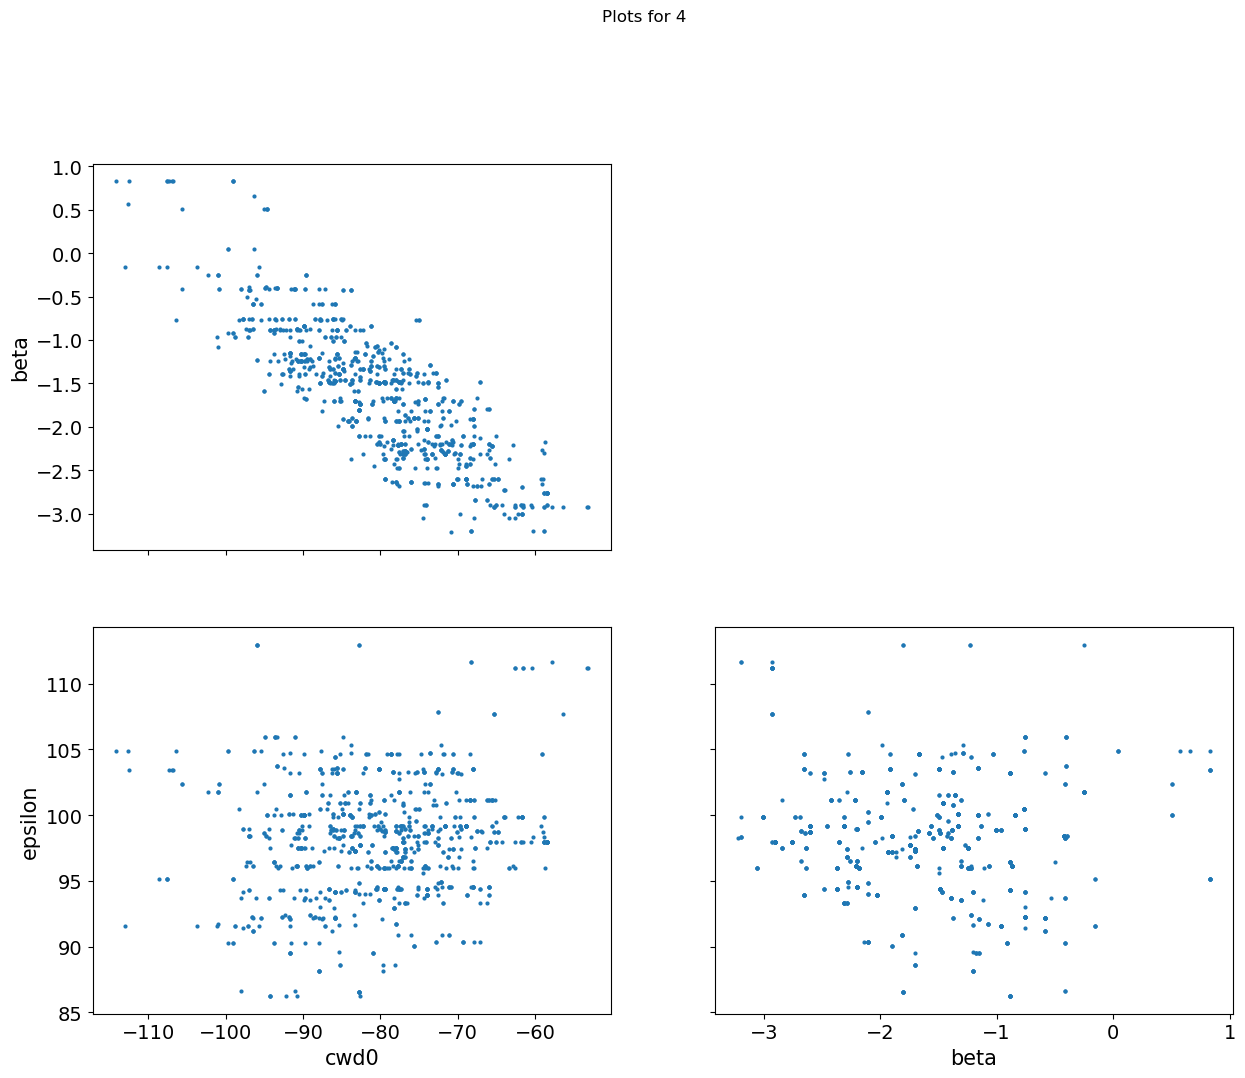

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


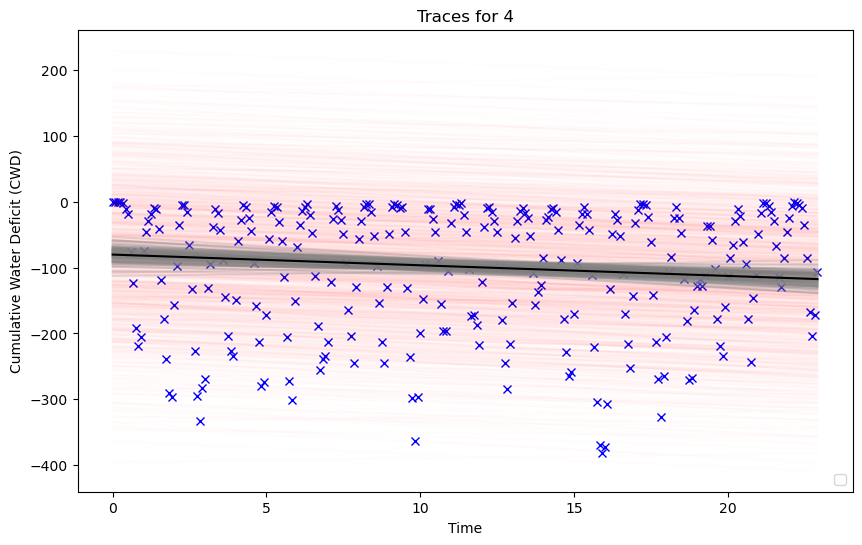

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [cwd0]
>Metropolis: [beta]


C:\Users\igor_\anaconda3\Lib\site-packages\pymc\step_methods\metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 39 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


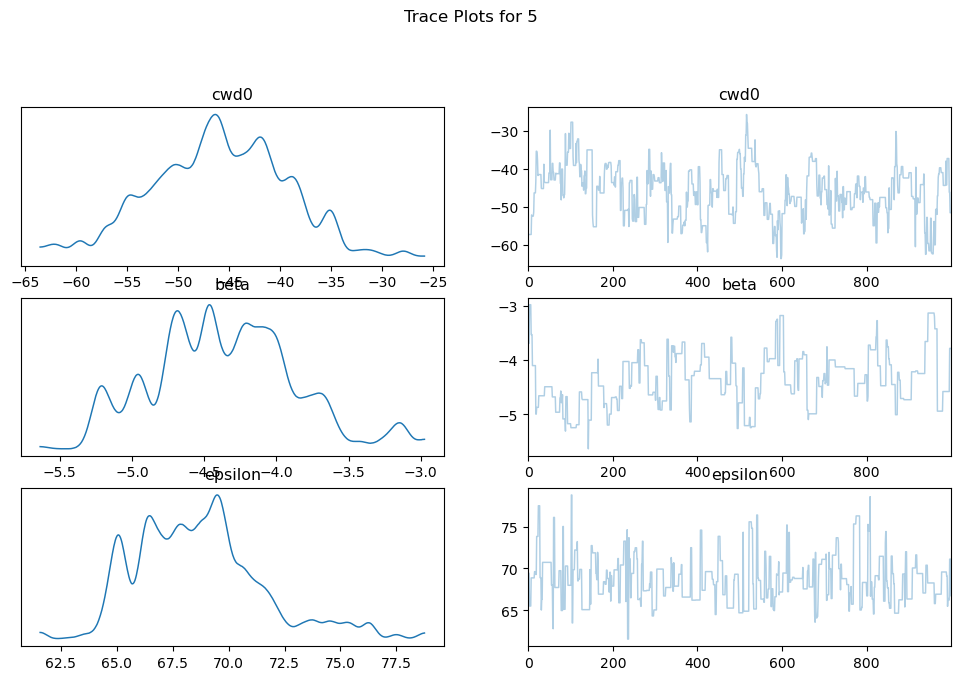

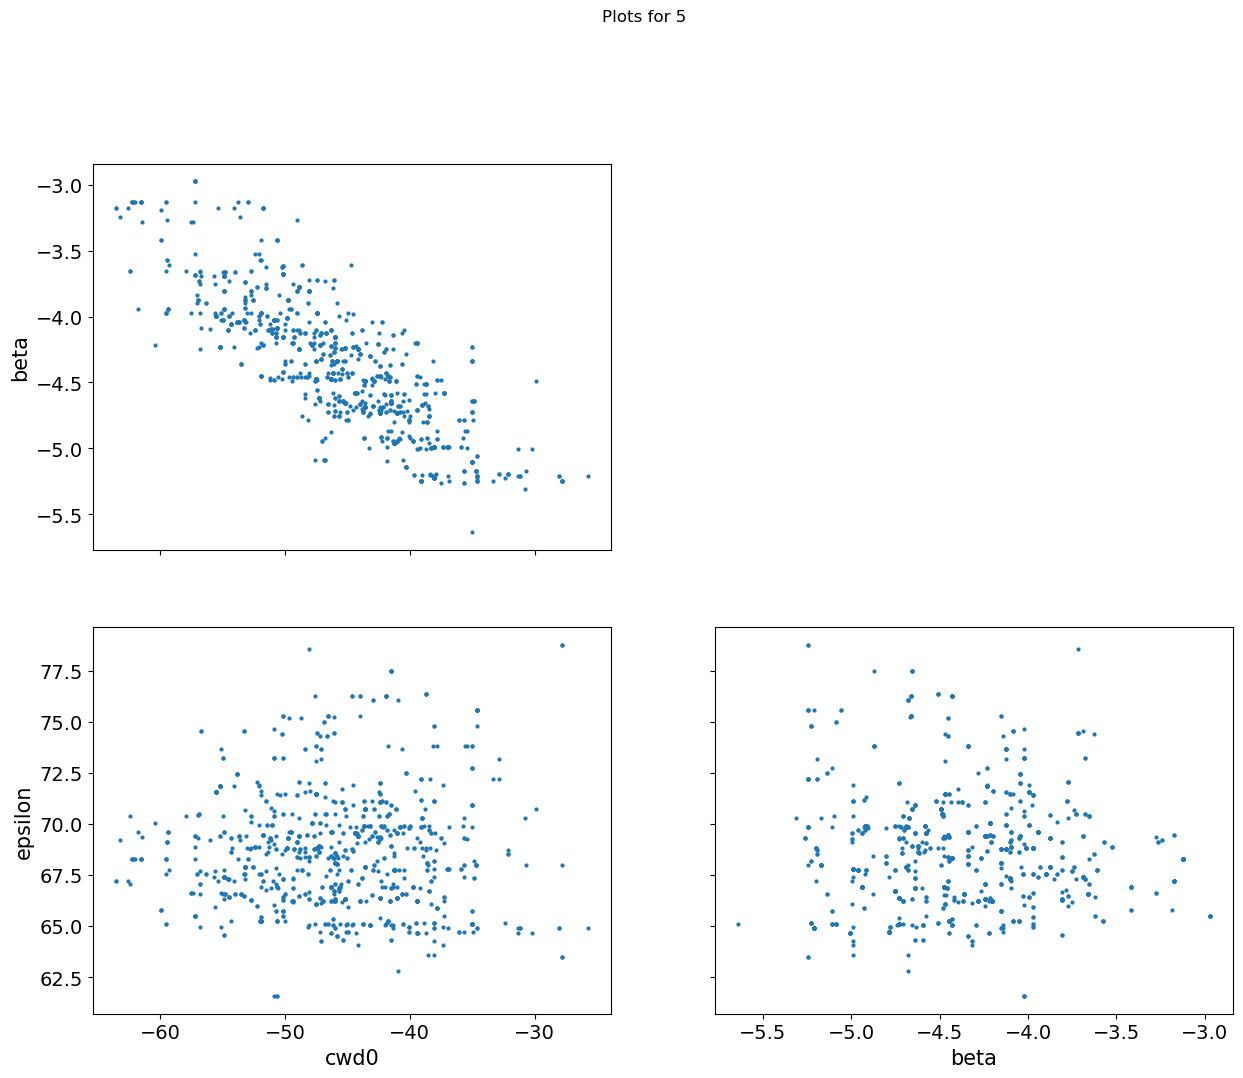

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


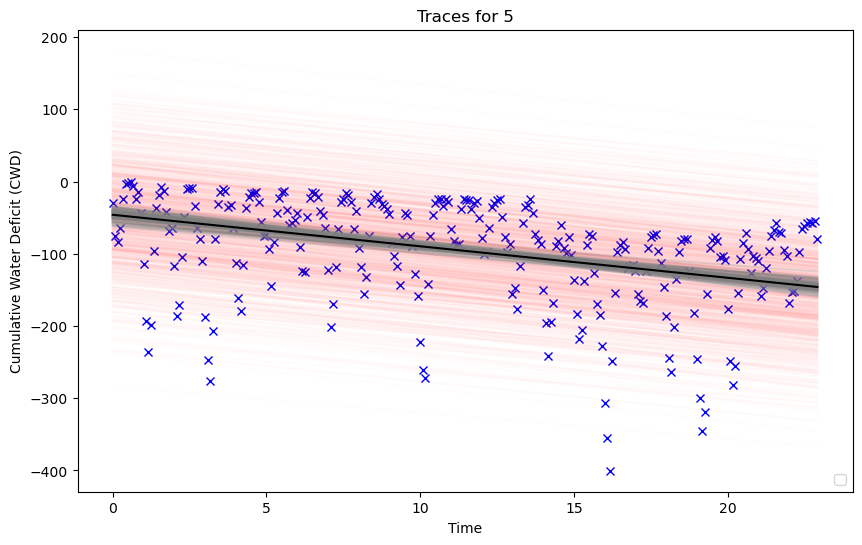

In [17]:
apply_bayesian_model()